In [1]:
# import modules
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

### Reflect Tables into SQL Alchemy ORM

In [62]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
inspector.get_table_names()


['measurement', 'station']

In [6]:
# show the table names and data types for future reference (measurement), view all of the classes that the automap found
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# show the table names and data types for future reference (station), view all of the classes that the automap found
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
Base = automap_base()
Base.prepare(autoload_with=engine)
measurement = Base.classes.measurement
station = Base.classes.station


In [10]:
# another way of connecting for the dataframes, below
conn = engine.connect()

In [35]:
# Save references to measurement data
measurement_data = pd.read_sql('SELECT * FROM measurement', conn)
measurement_data

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [36]:
# Save references to station data
station_data = pd.read_sql('SELECT * FROM station', conn)
station_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


### Exploratory Percipitation Analysis

In [43]:
# find the most recent (latest) date
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_measurement_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
prior_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("One year from last measurement: ", prior_12_months)

One year from last measurement:  2016-08-23


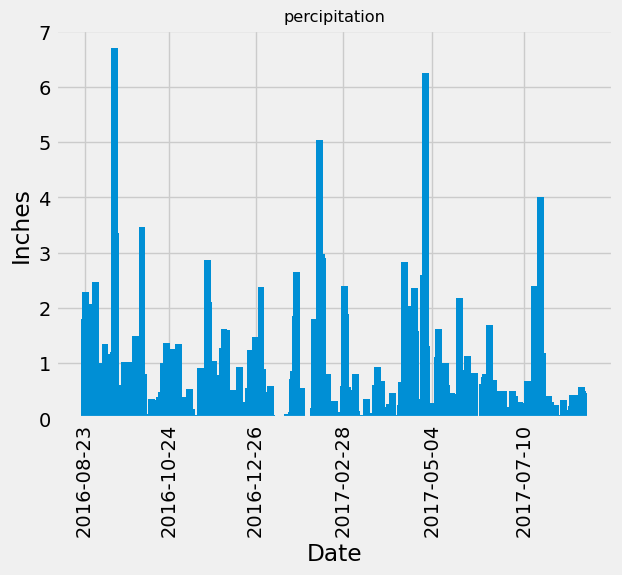

In [38]:
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date,
       measurement.prcp]
year_measurements =session.query(*sel).\
       filter(func.strftime('%Y-%m-%d', measurement.date) >= '2016-08-23').\
       order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names. Ordered by date in previous line of code
year_measurements = pd.DataFrame(year_measurements)
year_measurements.columns = ['date', 'percipitation']

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = year_measurements['date']
y_axis = year_measurements['percipitation']

plt.bar(x_axis, y_axis, width=5)

# space out the x-axis and change the orientation
plt.xticks(x_axis[::400], x_axis[::400])
plt.xticks(rotation='vertical')

# add labels
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('percipitation', fontsize='small')

plt.show()

In [40]:
# use Pandas to calculate the summary statistics for the percipitation data
meas_summary_stats = year_measurements.describe()
meas_summary_stats

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Exploratory Station Analysis

In [44]:
# design a query to calculate the total number of stations in the dataset
station_count = session.query(station.station).count()
print(f'There are {station_count} stations in the dataset')

There are 9 stations in the dataset


In [69]:
# design a query to find the most active stations (ie, which stations have the most rows?). List them in descending order. 
active = [measurement.station,
          func.count(measurement.id)]
most_active = session.query(*active).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [72]:
# using the most active station ID (USC00519281) from the previous query, calculate the lowest, highest and average temp. 
sel = [measurement.station,
       func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

temps = session.query(*sel).\
       filter(measurement.station == 'USC00519281').\
       group_by(measurement.station)
for station in temps:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


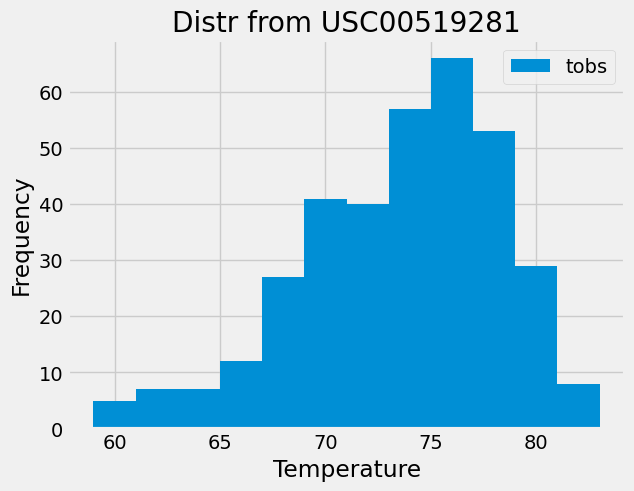

In [78]:
# using the most active station id query the last 12 months of temp observation data for this station and plot the results as a histogram

sel = [measurement.date,
       measurement.tobs]
station_temp = session.query(*sel).\
    filter(func.strftime(measurement.date) >= '2016-08-23', measurement.station == 'USC00519281').\
    group_by(measurement.date).\
    order_by(measurement.date).all()

station_temp_df = pd.DataFrame(station_temp)
station_temp_df.columns = ['date', 'temperature']

# create the histogram
plt.hist(station_temp_df['temperature'], bins=12, density=False, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distr from USC00519281')
plt.show()

In [79]:
session.close()